## Building a Spell Checker with NLP

In [3]:
import os, sys, gc, warnings
import logging, math, re, heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
from collections import Counter    
from nltk.tokenize import word_tokenize

In [4]:
# These settings help in proper formatting and display of the output of code we run
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
display(HTML(data="""<style>div#notebook-container { width:95%; }</style>"""))

In [5]:
import ast
import pandas as pd

df = pd.read_csv("dependency_treebank.csv", converters={'sentence': ast.literal_eval, 'tag': ast.literal_eval})

In [6]:
df.head(2)

,sentence,tag,file_id
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",1
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",1


In [7]:
def prepare_sentences(df):
    return [list(zip(row['sentence'], row['tag'])) for _, row in df.iterrows()]

tagged_sentences = prepare_sentences(df)

In [8]:
# Flattening the tagged sentences for model input
flattened_sentences = [pair for sentence in tagged_sentences for pair in sentence]
sentences, tags = zip(*flattened_sentences)

In [9]:
tags_counter = Counter(tags)
print(f"Number of Tags : {len(tags_counter)}")

Number of Tags : 45


In [10]:
tags_counter

Counter({'NN': 13166,
         'IN': 9857,
         'NNP': 9410,
         'DT': 8165,
         'NNS': 6047,
         'JJ': 5834,
         ',': 4886,
         '.': 3874,
         'CD': 3546,
         'VBD': 3043,
         'RB': 2822,
         'VB': 2554,
         'CC': 2265,
         'TO': 2179,
         'VBN': 2134,
         'VBZ': 2125,
         'PRP': 1716,
         'VBG': 1460,
         'VBP': 1321,
         'MD': 927,
         'POS': 824,
         'PRP$': 766,
         '$': 724,
         '``': 712,
         "''": 694,
         ':': 563,
         'WDT': 445,
         'JJR': 381,
         'NNPS': 244,
         'WP': 241,
         'RP': 216,
         'JJS': 182,
         'WRB': 178,
         'RBR': 136,
         '-RRB-': 126,
         '-LRB-': 120,
         'EX': 88,
         'RBS': 35,
         'PDT': 27,
         '#': 16,
         'WP$': 14,
         'LS': 13,
         'FW': 4,
         'UH': 3,
         'SYM': 1})

In [11]:
import plotly.express as px

# Let us plot a pie chart to see the distribution of different tags within the target column
px.bar(x = tags_counter.keys(), y = tags_counter.values(), title ='Total Count of Tags', color = tags_counter.keys())



In [12]:
def prepare_sentences(df):
    return [list(zip(row['sentence'], row['tag'])) for _, row in df.iterrows()]

tagged_sentences = prepare_sentences(df)

In [13]:
# Flattening the tagged sentences for model input
flattened_sentences = [pair for sentence in tagged_sentences for pair in sentence]
sentences, tags = zip(*flattened_sentences)

### LSTM

In [15]:
# Split the data into training and test sets
sentences_train, sentences_test, tags_train, tags_test = train_test_split(sentences, tags, random_state=42, test_size=0.1)

In [16]:
# Initialize tokenizer and encode sentences
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [17]:
# Pad sequences
max_length = max(len(x) for x in X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length, padding='post')

In [18]:
# Encode tags
tag_encoder = LabelEncoder()
y_train = tag_encoder.fit_transform(tags_train)
y_test = tag_encoder.transform(tags_test)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [19]:
# Define a simple model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
output_dim = len(tag_encoder.classes_)

In [21]:
def build_simple_model(vocab_size, embedding_dim, max_length, output_dim):
    inputs = Input(shape=(max_length,))
    x = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    x = LSTM(128, return_sequences=True)(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(output_dim, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build the model
model = build_simple_model(vocab_size, embedding_dim, max_length, output_dim)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 4, 100)         │       937,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4, 128)         │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 45)             │         5,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,077,465 (4.11 MB)

 Trainable params: 1,077,465 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model and save the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5444 - loss: 1.5804 - val_accuracy: 0.7870 - val_loss: 0.6532
Epoch 2/10
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8244 - loss: 0.5306 - val_accuracy: 0.8003 - val_loss: 0.5823
Epoch 3/10
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8493 - loss: 0.4275 - val_accuracy: 0.8067 - val_loss: 0.5574
Epoch 4/10
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8573 - loss: 0.3865 - val_accuracy: 0.8069 - val_loss: 0.5653
Epoch 5/10
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8561 - loss: 0.3725 - val_accuracy: 0.8096 - val_loss: 0.5665
Epoch 6/10
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8621 - loss: 0.3581 - val_accuracy: 0.8092 - val_loss: 0.5618
Epoch 7/10
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8627 - loss: 0.3514 - val_accuracy: 0.8060 - val_loss: 0.5796
Epoch 8/10
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8660 - loss: 0.3

In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7967 - loss: 1.0070
Test loss: 0.9693, Test accuracy: 0.8011


### NLP Tasks


- Real-world data are often incomplete, inconsistent, inaccurate, and lack specifically required trend. Therefore, data preprocessing is a primary and most significant step in natural language processing (NLP). It is a crucial process as it directly affects the success rate of the model. The typical steps involved in data preprocessing are:

- Lexical Processing tasks like tokenization, stop word removal, stemming, lemmatization, TF-IDF representation

In [28]:
# Loading the Dataset
dataframe = pd.read_csv("ner_dataset.csv",encoding = 'ISO-8859-1')

# Dropping the missing values from the dataset and reset the index for better visualization and down stream applications
dataframe = dataframe.dropna()
dataframe = dataframe.reset_index(drop=True)

# Let us see how the text in the data looks like after dropping the missing values. 
dataframe.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 2,Families,NNS,O
2,Sentence: 3,They,PRP,O
3,Sentence: 4,Police,NNS,O
4,Sentence: 5,The,DT,O


In [29]:
import plotly.express as px

# Unique tags in the datset
dataframe.Tag.unique()
print(f"Number of Tags : {len(dataframe.Tag.unique())}")

array(['O', 'B-gpe', 'B-geo', 'B-per', 'B-org', 'B-tim', 'B-nat', 'B-eve',
       'B-art'], dtype=object)

Number of Tags : 9


In [30]:
# Let us plot a pie chart to see the distribution of different tags within the target column
pie = dataframe['Tag'].value_counts()
px.pie(names = pie.index,values= pie.values,hole = 0.5,title ='Total Count of Tags')

In [31]:
# We can also do a similar distribution of parts of speech in the data set using a bar chart. Let us plot it here.
bar = dataframe['POS'].value_counts()
px.bar(x = bar.index,y = bar.values,title = "Total Count of Parts of Speech",color = bar.index)

In [32]:
# Get top words from each tag based on their frequency
for tag in dataframe['Tag'].unique():
    print('')
    print('Tag-',tag)
    dataframe[dataframe['Tag']==tag]['Word'].value_counts().head(3)


Tag- O


Word
The    10959
A       2186
In      1719
Name: count, dtype: int64


Tag- B-gpe


Word
Iraqi      231
Israeli    186
Afghan     165
Name: count, dtype: int64


Tag- B-geo


Word
U.S.     290
Iran     264
China    222
Name: count, dtype: int64


Tag- B-per


Word
Mr.          1421
President     408
Ms.            93
Name: count, dtype: int64


Tag- B-org


Word
U.S.    201
The     176
VOA     126
Name: count, dtype: int64


Tag- B-tim


Word
Thursday    63
Tuesday     61
Monday      58
Name: count, dtype: int64


Tag- B-nat


Word
Katrina    5
Paul       2
Marburg    2
Name: count, dtype: int64


Tag- B-eve


Word
IRAQ-POVERTY    1
Typhoon         1
Katrina         1
Name: count, dtype: int64


Tag- B-art


Word
GDP             2
SpaceShipOne    2
Phoenix         2
Name: count, dtype: int64

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define MAX_LEN
MAX_LEN = 128

In [34]:
# Grouping, Tokenizing and Padding
dataframe["Sentence #"] = dataframe["Sentence #"].fillna(method="ffill")
sentence = dataframe.groupby("Sentence #")["Word"].apply(list).values
pos = dataframe.groupby(by = 'Sentence #')['POS'].apply(list).values
tag = dataframe.groupby(by = 'Sentence #')['Tag'].apply(list).values

### Process Dataset

In [35]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def process_data(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    pos = df.groupby("Sentence #")["POS"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values

    # Remove sentences with nan values
    cleaned_sentences = []
    cleaned_tag = []
    for i in range(len(sentences)):
        if not any(pd.isna(word) for word in sentences[i]):
            cleaned_sentences.append(sentences[i])
            cleaned_tag.append(tag[i])

    return cleaned_sentences, pos, cleaned_tag, enc_pos, enc_tag

In [36]:
# Apply the function on our dataset
sentences, pos, tag, enc_pos, enc_tag = process_data("ner_dataset.csv")

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, tag, random_state=42, test_size=0.1)
print(len(X_train), len(X_test), len(y_train), len(y_test))

43154 4795 43154 4795


In [37]:
# # Here we will split the dataset into 90 10 splits.
# X_train,X_test,y_train,y_test = train_test_split(sentence, tag, random_state=42, test_size=0.1)
# X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Instantiate the Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to encode data using the tokenizer
def encode_data(data, tokenizer, max_len=MAX_LEN):
    input_ids = []
    attention_mask = []
    for sentence in data:
        encoded = tokenizer.encode_plus(
            sentence, 
            add_special_tokens=True, 
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            max_length=max_len,
            is_split_into_words=True
        )
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_mask)

# Encode training data
input_ids, attention_mask = encode_data(X_train, tokenizer)

# Pad tag sequences
train_tag = pad_sequences(y_train, maxlen=MAX_LEN, padding='post', truncating='post', value=0)
test_tag = pad_sequences(y_test, maxlen=MAX_LEN, padding='post', truncating='post', value=0)

# Encode validation/test data
val_input_ids, val_attention_mask = encode_data(X_test, tokenizer)

BERT stands for Bidirectional Encoder Representations and is based on Transformers in which every output element is connected to every input element and the weightings between them are dynamically calculated based upon their connection.
BERT is also an open-source machine learning framework for natural language processing (NLP) and is designed to help computers understand the meaning of ambiguous language in text by using surrounding text to establish context.

The BERT framework was pre-trained using text from Wikipedia and can be fine-tuned with question and answer datasets.
Bert model is based on the concept of masked language modeling which works by inserting a mask token at the desired position where we want to predict the best candidate word that would go in that position. These tokens are processed in the previous step.

Bert Model for Masked Language Modeling predicts the best word or token in the vocabulary that would replace that word. The logits are the output of the BERT Model before a softmax activation function is applied to the output of BERT.
We apply a softmax onto the output of BERT to get probabilistic distributions for each of the words in BERT’s vocabulary. The words with a higher probability value will be better candidate replacement words for the mask token.


In [39]:
# Define a custom layer to wrap the BERT model
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert_model(input_ids, attention_mask=attention_mask, return_dict=True)
        return outputs["last_hidden_state"]

In [40]:
def create_model(bert_model, max_len=MAX_LEN):
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    bert_layer = BertLayer(bert_model)([input_ids, attention_masks])
    embedding = tf.keras.layers.Dropout(0.3)(bert_layer)
    output = tf.keras.layers.Dense(17, activation='softmax')(embedding)
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

In [41]:
# Define the distribution strategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    model = create_model(bert_model, MAX_LEN)

# Training and evaluation
early_stopping = EarlyStopping(mode='min', patience=5)

history_bert = model.fit([input_ids, attention_mask], train_tag, 
                         validation_data=([val_input_ids, val_attention_mask], test_tag), 
                         epochs=2, batch_size=60, 
                         callbacks=[early_stopping], verbose=True)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


2024-07-19 19:11:35.652190: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0693 - loss: 3.0666

2024-07-19 20:11:46.718188: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


720/720 ━━━━━━━━━━━━━━━━━━━━ 4004s 6s/step - accuracy: 0.0694 - loss: 3.0662 - val_accuracy: 0.3492 - val_loss: 2.1896
Epoch 2/2


2024-07-19 20:18:19.612392: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


403/720 ━━━━━━━━━━━━━━━━━━━━ 28:36 5s/step - accuracy: 0.3829 - loss: 2.1321

Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

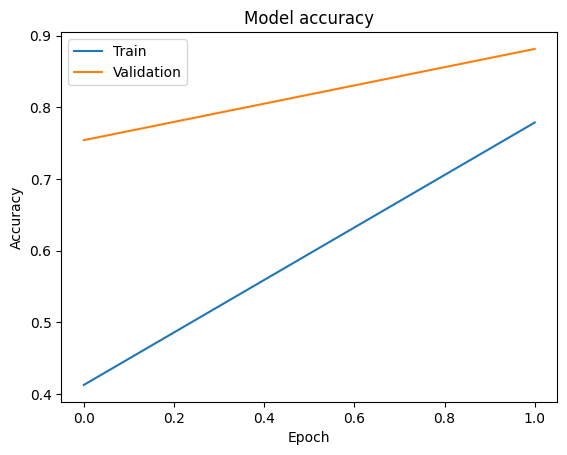

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

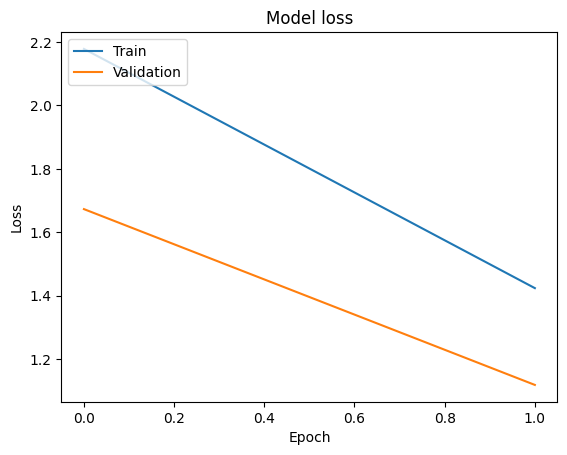

In [25]:
# If we want to save the model weights, we can do it simply uncommenting the following step. 
# model.save_weights("ner_bert_weights")

# Plot the model accuracy across epochs
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the model train and validation loss across epochs
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()